# CDS ML Assignment 3
##### Group 37 - Rahul Deivasigamani (S1157698) - Joshua John Gigi (S1140063) - Anestis Pantazis (S1169388)

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image

import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
from IPython import display

#### Ex 5.1
Study the performance properties of the convolutional network provided in the introductory [pytorch tutorial](https://docs.pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html).

How is learning affected if instead of ReLU units, tanh() activations are used? What is the reason for this? Compare also at least two different optimizer algorithms.

In [ ]:
data_folder = './data'

batch_size = 4

# define transforms and dataloaders
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root=data_folder, train=True,
                                        download=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root=data_folder, train=False,
                                       download=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

In [4]:
torch.manual_seed(12345)

# Use the GPU if available
def detect_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    elif torch.backends.mps.is_available():
        return torch.device("mps")
    else:
        return torch.device("cpu")

device = detect_device()
device

device(type='cuda')

In [5]:
def accuracy(pred_y, true_y):
    correct = pred_y.argmax(dim=1) == true_y
    return int(correct.sum()) / len(true_y)

class Metrics:
    """Accumulate mean values of one or more metrics."""
    def __init__(self, n):
        self.count = 0
        self.sum = (0,) * n
    def add(self, count, *values):
        self.count += count
        self.sum = tuple(s + count * v for s,v in zip(self.sum,values))
    def mean(self):
        return tuple(s / self.count for s in self.sum)

def evaluate(net, test_loader, loss_function=torch.nn.CrossEntropyLoss(), device=device):
    """
    Evaluate a model on the given dataset.
    Return loss, accuracy
    """
    # Note: we can use a large batch size for efficiency, it doesn't matter for the computed loss or accuracy
    with torch.no_grad():
        net.eval()
        metrics = Metrics(2)
        for x, y in test_loader:
            x = x.to(device)
            y = y.to(device)
            pred_y = net(x)
            loss = loss_function(pred_y, y)
            acc = accuracy(pred_y, y)
            metrics.add(len(y), loss.item(), acc)
        return metrics.mean()

In [6]:
class Plotter:
    """For plotting data in animation."""
    # Based on d2l.Animator
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        """Defined in :numref:`sec_utils`"""
        # Incrementally plot multiple lines
        if legend is None:
            legend = []
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # Use a function to capture arguments
        def config_axes():
            axis = self.axes[0]
            axis.set_xlabel(xlabel), axis.set_ylabel(ylabel)
            axis.set_xscale(xscale), axis.set_yscale(yscale)
            axis.set_xlim(xlim),     axis.set_ylim(ylim)
            if legend:
                axis.legend(legend)
            axis.grid()
        self.config_axes = config_axes
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # Add multiple data points into the figure
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

In [7]:
def train_sgd(net, train_loader, validation_loader, num_epochs, lr, momentum, device=device):
    """
    Train a network on the given training data.
    After every epoch compute validation loss and accuracy.
    """
    net.to(device)
    net.train()
    num_batches = len(train_loader)
    loss_function = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum)
    # optimizer = optim.Adam(net.parameters(), lr=lr, momentum=momentum)
    plotter = Plotter(xlabel='epoch', xlim=[1, num_epochs],
                      legend=['train loss', 'train acc', 'val loss', 'val acc'])
    start_time = time.time()
    for epoch in range(num_epochs):
        # Sum of training loss, sum of training accuracy, no. of examples
        metrics = Metrics(2)
        for i, (x, y) in enumerate(train_loader):
            optimizer.zero_grad()
            x = x.to(device)
            y = y.to(device)
            pred_y = net(x)
            loss = loss_function(pred_y, y)
            loss.backward()
            optimizer.step()
            with torch.no_grad():
                acc = accuracy(pred_y, y)
                metrics.add(len(y), loss.item(), acc)
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                train_loss, train_acc = metrics.mean()
                plotter.add(epoch + (i + 1) / num_batches, (train_loss, train_acc, None, None))
        val_loss, val_acc = evaluate(net, validation_loader, loss_function=loss_function, device=device)
        plotter.add(epoch + 1, (None, None, val_loss, val_acc))
    train_loss, train_acc = metrics.mean()
    train_time = time.time() - start_time
    print(f'train loss {train_loss:.3f}, train acc {train_acc:.3f}, '
          f'val loss {val_loss:.3f}, val acc {val_acc:.3f}')
    print(f'{metrics.count * num_epochs / train_time:.1f} examples/sec '
          f'on {str(device)}')
    return plotter

In [8]:
def train_adam(net, train_loader, validation_loader, num_epochs, lr, device=device):
    """
    Train a network on the given training data.
    After every epoch compute validation loss and accuracy.
    """
    net.to(device)
    net.train()
    num_batches = len(train_loader)
    loss_function = nn.CrossEntropyLoss()
    # optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum)
    optimizer = optim.Adam(net.parameters(), lr=lr)
    plotter = Plotter(xlabel='epoch', xlim=[1, num_epochs],
                      legend=['train loss', 'train acc', 'val loss', 'val acc'])
    start_time = time.time()
    for epoch in range(num_epochs):
        # Sum of training loss, sum of training accuracy, no. of examples
        metrics = Metrics(2)
        for i, (x, y) in enumerate(train_loader):
            optimizer.zero_grad()
            x = x.to(device)
            y = y.to(device)
            pred_y = net(x)
            loss = loss_function(pred_y, y)
            loss.backward()
            optimizer.step()
            with torch.no_grad():
                acc = accuracy(pred_y, y)
                metrics.add(len(y), loss.item(), acc)
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                train_loss, train_acc = metrics.mean()
                plotter.add(epoch + (i + 1) / num_batches, (train_loss, train_acc, None, None))
        val_loss, val_acc = evaluate(net, validation_loader, loss_function=loss_function, device=device)
        plotter.add(epoch + 1, (None, None, val_loss, val_acc))
    train_loss, train_acc = metrics.mean()
    train_time = time.time() - start_time
    print(f'train loss {train_loss:.3f}, train acc {train_acc:.3f}, '
          f'val loss {val_loss:.3f}, val acc {val_acc:.3f}')
    print(f'{metrics.count * num_epochs / train_time:.1f} examples/sec '
          f'on {str(device)}')
    return plotter

In [9]:
cnn_sgd = nn.Sequential(
    nn.Conv2d(3, 6, 5),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(6, 16, 5),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Flatten(),
    nn.Linear(16 * 5 * 5, 120),
    nn.ReLU(),
    nn.Linear(120, 84),
    nn.ReLU(),
    nn.Linear(84, 10)
)

In [10]:
cnn_adam = nn.Sequential(
    nn.Conv2d(3, 6, 5),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(6, 16, 5),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Flatten(),
    nn.Linear(16 * 5 * 5, 120),
    nn.ReLU(),
    nn.Linear(120, 84),
    nn.ReLU(),
    nn.Linear(84, 10)
)

In [11]:
cnn_tan_h_sgd = nn.Sequential(
    nn.Conv2d(3, 6, 5),
    nn.Tanh(),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(6, 16, 5),
    nn.Tanh(),
    nn.MaxPool2d(2, 2),
    nn.Flatten(),
    nn.Linear(16 * 5 * 5, 120),
    nn.Tanh(),
    nn.Linear(120, 84),
    nn.Tanh(),
    nn.Linear(84, 10)
)

In [12]:
cnn_tan_h_adam = nn.Sequential(
    nn.Conv2d(3, 6, 5),
    nn.Tanh(),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(6, 16, 5),
    nn.Tanh(),
    nn.MaxPool2d(2, 2),
    nn.Flatten(),
    nn.Linear(16 * 5 * 5, 120),
    nn.Tanh(),
    nn.Linear(120, 84),
    nn.Tanh(),
    nn.Linear(84, 10)
)

The models were run with parameters provided in the tutorial. We can see that most of the models haven't converged given the parameters. The factors affecting the accuracy are - learning rate, optimizer used, weight initialisation. 

#### SGD with ReLu

train loss 0.617, train acc 0.802, val loss 2.206, val acc 0.570
989.1 examples/sec on cuda


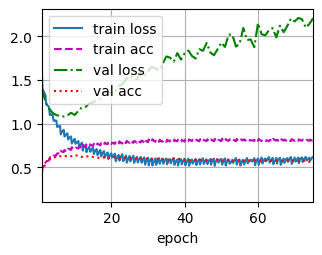

In [36]:
plotter_relu_sgd = train_sgd(net=cnn_sgd, train_loader=trainloader, validation_loader=testloader, num_epochs=75, lr=1e-3, device=device, momentum=0.9)

We can see that training converged successfully. But during inference, we can observe that it has not generalised very well. Instead it has overfitted on the training data. If we submit an input image which is already in the training set, it predicts correctly. For a test image which exists only on the test-dataset, it fails. The validation accuracy, 0.6, indicates that the model is just a slightly better guess machine. The increasing loss is an indicator of this overfitting.

#### SGD with TanH

train loss 0.478, train acc 0.827, val loss 1.841, val acc 0.547
1072.0 examples/sec on cuda


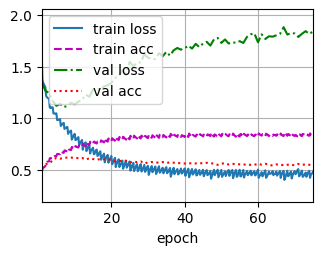

In [13]:
plotter_tanh_sgd = train_sgd(net=cnn_tan_h_sgd, train_loader=trainloader, validation_loader=testloader, num_epochs=75, lr=1e-3, device=device, momentum=0.9)

Using tanh as the activation function, the training has converged. However the model has still overfitted on the training data. The curves are less noisy and more smooth. It gives a slightly better performance compared to the one using ReLU. However it is still no better than a guessing machine. The training accuracy and loss is 0.827 and 0.478 respectively. The validation accuracy and loss are 0.547 and 1.841 respectively.

#### Adam with ReLu

train loss 0.683, train acc 0.773, val loss 2.327, val acc 0.598
975.5 examples/sec on cuda


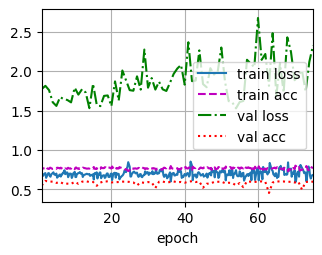

In [16]:
plotter_relu_adam = train_adam(net=cnn_adam, train_loader=trainloader, validation_loader=testloader, num_epochs=75, lr=1e-3, device=device)

Using Adam optimisation we can see that both accuracies are flat and remain same across all epochs. However we can see that validation loss shows a general pattern of increasing. Hence this approach cannot be reliably used. For training, the accuracy is 0.773 and the loss 0.683. However, for validation, the accuracy is  0.598 with a overwhelming loss of 2.327. Since curves are parallel and dont really converge, this can be said to be a bad model. SGD shows very wide variations in the loss curves. The model underfits on the data.

#### Adam with TanH

train loss 1.054, train acc 0.629, val loss 1.278, val acc 0.563
1006.1 examples/sec on cuda


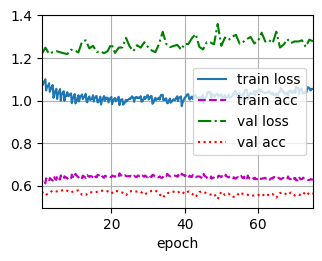

In [17]:
plotter_tanh_adam = train_adam(net=cnn_tan_h_adam, train_loader=trainloader, validation_loader=testloader, num_epochs=75, lr=1e-3, device=device)

The training loss is 1.054 and the accuracy is 0.629. The validation loss is 1.278 and the accuracy 0.563. Loss is overwhelmingly more than the accuracy. The graph implies that it is underfitting on the data. However the curves are more smoother compared to the one using the SGD optimizer. Hence it can be said that it is a bad model.

We can improve these models with a variety of approaches like He initialisation or adding more augmentation to the input images like dilation or padding.

#### Ex 5.2
Try to outperform the convolutional network of **Ex 5.1** with a multilayer perceptron (MLP) that uses approximately the same number of parameters.
Report your results and explain them.

#### Ex 5.3

Learning convolutions from scratch starting from a fully connected initialization is hard.

Reproduce the emergence of localized receptive fields in a one-hidden layer fully connected network as described in [this paper](https://www.pnas.org/doi/abs/10.1073/pnas.2201854119). For simplicity, use a 1-dimensional version of the GP and NLGP synthetic data models described in the Methods sections. Use a network with $K=30$ hidden neurons, fixed second-layer weights and $\text{erf}(x/\sqrt{2})$ activation function. Feel free to use either a fixed dataset or work in an online learning setting, where new inputs are produced before each gradient step.